In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import linalg as LA
from collections import Counter
import seaborn as sns
import numpy as np
import pickle

In [2]:
import pyLDAvis

%matplotlib inline

In [3]:
import sys

#path_to_lda2vec = "/Users/sophialiu/anaconda3/envs/lda2vec_tensor/"
path_to_lda2vec = "./lda2vec/"

sys.path.append(path_to_lda2vec)

In [4]:
import warnings

warnings.filterwarnings('ignore')  # ignore warnings.

# Pre-processing and Data Explore

In [5]:
df = pd.read_csv(u'./sample_data.csv', dtype={'verbatum':object})

df.head()

,snippet,product,rating,verbatim,sentiment_binary,sentiment,date,retailer,website,topic
0,This shampoo sprays crazy good and it has save...,Head And Shoulders Smooth & Silky Dandruff Sha...,5,This shampoo sprays crazy good and it has save...,1,Positive,5/2/2018,-,https://www.walmart.com/ip/Head-and-Shoulders-...,Spray Application
1,The thing I always remember about Head & Shoul...,Head And Shoulders Green Apple Anti-Dandruff S...,5,My teenaged daughter has been using Head & Sho...,1,Positive,9/29/2017,AMZ,https://www.amazon.com/Head-Shoulders-Anti-Dan...,Spray Application
2,"My long, thick, wavy, hair is frequently abuse...",Dove Dermacare Scalp Anti-Dandruff Shampoo Inv...,4,"To my surprise, Dove DermaCare Scalp Invigorat...",1,Positive,1/27/2017,WALMART,https://www.walmart.com/ip/Dove-Dermacare-Scal...,Spray Application
3,"From their body sprays, to their deodorant, so...",Dove Dermacare Scalp Anti-Dandruff Shampoo Dry...,5,I let my boyfriend try this product. He loves ...,1,Positive,1/27/2017,-,https://www.walmart.com/ip/Dove-Dermacare-Scal...,Spray Application
4,"Its conveniently packaged, but if this bottle ...","Head And Shoulders Dry Scalp Care, Almond Oil,...",4,"Its conveniently packaged, but if this bottle ...",1,Positive,1/14/2016,AMZ,https://www.amazon.com/Head-Shoulders-Almond-D...,Spray Application


In [7]:
df.dropna(subset=['verbatim'], inplace=True)

In [8]:
df.shape

(49657, 10)

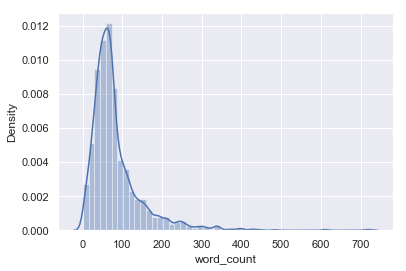

In [10]:
s = df['verbatim'].apply(lambda x: len(x.split()))
df['word_count'] = s

sns.set(color_codes=True)
sns.distplot(df['word_count'])

In [13]:
#word_count = df['verbatum'].str.split(expand=True).stack.value_counts()
df_word_freq = (df['verbatim'].str.split(expand=True)
                .stack()
                .value_counts()
                .rename_axis('word')
                .reset_index(name='count'))
df_word_freq[:10]

,word,count
0,I,180538
1,and,141072
2,the,112821
3,a,111602
4,my,101072
5,it,84013
6,to,79414
7,this,70578
8,of,67189
9,hair,57111


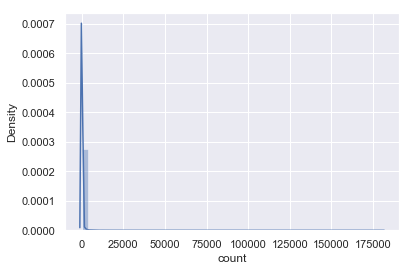

In [14]:
sns.set(color_codes=True)
sns.distplot(df_word_freq['count'])

In [17]:
df_word_freq.describe()

,count
count,18376.000000
mean,224.738354
std,2849.989237
min,1.000000
25%,6.000000
50%,12.000000
75%,33.000000
max,180538.000000


In [19]:
import pandas as pd
from lda2vec.nlppipe import Preprocessor

# Initialize a preprocessor
P = Preprocessor(df, "verbatim", max_features=30000, maxlen=10000, min_count=5)

# Run the preprocessing on your dataframe
P.preprocess()


---------- Tokenizing Texts ----------


49657it [03:03, 271.23it/s]


Removing 1081 low frequency tokens out of 7767 total tokens

---------- Getting Skipgrams ----------


49657it [00:41, 1207.23it/s]


In [20]:
load_embeds = True

In [23]:
if load_embeds:
    embedding_matrix = P.load_glove("./glove/glove.twitter.27B.200d.txt")
else:
    embedding_matrix = None

In [24]:
# Save data to data_dir
clean_data_dir = "./lda2vec_clean"
P.save_data(clean_data_dir, embedding_matrix=embedding_matrix)

# Use the Model

In [25]:
from lda2vec import utils # , model
from lda2vec import Lda2vec

# Path to preprocessed data
data_path  = clean_data_dir
# Whether or not to load saved embeddings file
load_embeds = True

# Load data from files
(idx_to_word, word_to_idx, freqs, pivot_ids,
 target_ids, doc_ids, embed_matrix) = utils.load_preprocessed_data(data_path, load_embed_matrix=load_embeds)


In [26]:
print(len(idx_to_word.keys())) # {1: hair}
print(list(idx_to_word.values())[:10])

6686
['hair', 'shampoo', 'product', 'scalp', 'dandruff', 'review', 'head', 'use', 'dry', 'smell']


In [27]:
len(word_to_idx.keys()) 

6686

In [28]:
print(len(freqs)) # The frequences
print(freqs[:10])

6686
[0, 71165, 60516, 42913, 42577, 40035, 26215, 24267, 22564, 22078]


In [29]:
len(pivot_ids)

15632012

In [30]:
len(target_ids)

15632012

In [31]:
len(doc_ids)

15632012

In [32]:
embed_matrix.shape

(6686, 200)

Set the Hyper-parameters for model creation.

In [33]:
# Number of unique documents
num_docs = doc_ids.max() + 1
# Number of unique words in vocabulary (int)
vocab_size = len(freqs)
# Embed layer dimension size
# If not loading embeds, change 128 to whatever size you want.
embed_size = embed_matrix.shape[1] if load_embeds else 128
# Number of topics to cluster into
num_topics = 10
# Amount of iterations over entire dataset
num_epochs = 100
# Batch size - Increase/decrease depending on memory usage
batch_size = 4096
# Epoch that we want to "switch on" LDA loss
switch_loss_epoch = 0
# Pretrained embeddings value
pretrained_embeddings = embed_matrix if load_embeds else None
# If True, save logdir, otherwise don't
save_graph = False

logdir = '/Users/sophialiu/Desktop/logdir'

In [34]:
from lda2vec import utils # , model
from lda2vec import Lda2vec

# Initialize the model
m = Lda2vec.Lda2vec(num_docs,
            vocab_size,
            num_topics,
            embedding_size=embed_size,
            pretrained_embeddings=pretrained_embeddings,
            freqs=freqs,
            batch_size = batch_size,
            save_graph_def=save_graph,
            logdir = logdir)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [35]:
# Train the model
m.train(pivot_ids,
        target_ids,
        doc_ids,
        len(pivot_ids),
        num_epochs,
        idx_to_word=idx_to_word,
        switch_loss_epoch=switch_loss_epoch)


EPOCH: 1
LOSS 53576.055 w2v 10.189205 lda 53565.867

EPOCH: 2
LOSS 53571.13 w2v 5.2349286 lda 53565.895

EPOCH: 3
LOSS 53571.336 w2v 5.427567 lda 53565.91

EPOCH: 4
LOSS 53572.223 w2v 6.2968817 lda 53565.926

EPOCH: 5
LOSS 53571.133 w2v 5.199053 lda 53565.934
---------Closest 10 words to given indexes----------
Topic 0 : shampoo, scalp, product, dandruff, promotion, review, soft, impressed, helped, silky
Topic 1 : shampoo, scalp, product, dandruff, promotion, review, soft, impressed, helped, silky
Topic 2 : shampoo, scalp, product, dandruff, promotion, review, soft, impressed, helped, silky
Topic 3 : shampoo, scalp, product, dandruff, promotion, review, soft, impressed, helped, silky
Topic 4 : shampoo, scalp, product, dandruff, promotion, review, soft, impressed, helped, silky
Topic 5 : shampoo, scalp, product, dandruff, promotion, review, soft, impressed, helped, silky
Topic 6 : shampoo, scalp, product, dandruff, promotion, review, soft, impressed, helped, silky
Topic 7 : shampoo, sc

LOSS 53570.43 w2v 4.4948006 lda 53565.934

EPOCH: 37
LOSS 53570.645 w2v 4.716314 lda 53565.93

EPOCH: 38
LOSS 53570.434 w2v 4.500279 lda 53565.934

EPOCH: 39
LOSS 53570.08 w2v 4.144864 lda 53565.934

EPOCH: 40
LOSS 53570.344 w2v 4.408598 lda 53565.934
---------Closest 10 words to given indexes----------
Topic 0 : hair, dandruff, product, shampoo, opinioni, recoeved, review, scalp, mositurized, separates
Topic 1 : hair, dandruff, product, shampoo, opinioni, recoeved, review, scalp, mositurized, separates
Topic 2 : hair, dandruff, product, shampoo, opinioni, recoeved, review, scalp, mositurized, separates
Topic 3 : hair, dandruff, product, shampoo, opinioni, recoeved, review, scalp, mositurized, separates
Topic 4 : hair, dandruff, product, shampoo, opinioni, recoeved, review, scalp, mositurized, separates
Topic 5 : hair, dandruff, product, shampoo, opinioni, recoeved, review, scalp, mositurized, separates
Topic 6 : hair, dandruff, product, shampoo, opinioni, recoeved, review, scalp, mosi

LOSS 53571.008 w2v 5.0761642 lda 53565.934

EPOCH: 72
LOSS 53570.08 w2v 4.143955 lda 53565.934

EPOCH: 73
LOSS 53570.82 w2v 4.891258 lda 53565.93

EPOCH: 74
LOSS 53571.023 w2v 5.091361 lda 53565.934

EPOCH: 75
LOSS 53570.273 w2v 4.3397317 lda 53565.934
---------Closest 10 words to given indexes----------
Topic 0 : recoeved, mositurized, dandruff, hair, review, shampoo, curley, scalp, separates, victim
Topic 1 : recoeved, mositurized, dandruff, hair, review, shampoo, curley, scalp, separates, victim
Topic 2 : recoeved, mositurized, dandruff, hair, review, shampoo, curley, scalp, separates, victim
Topic 3 : recoeved, mositurized, dandruff, hair, review, shampoo, curley, scalp, separates, victim
Topic 4 : recoeved, mositurized, dandruff, hair, review, shampoo, curley, scalp, separates, victim
Topic 5 : recoeved, mositurized, dandruff, hair, review, shampoo, curley, scalp, separates, victim
Topic 6 : recoeved, mositurized, dandruff, hair, review, shampoo, curley, scalp, separates, victim
T

From the running output, we can see that the lda_loss is not optimized at all... And the topics are not getting more and more "sparse" or "different" as shown in the paper.

In [39]:
# save weight to file.

"""
m.save_weights_to_file(
    word_embed_path ='./lda2vec_weights/word', 
    doc_embed_path  ='./lda2vec_weights/doc',
    topic_embed_path='./lda2vec_weights/topic'
)
"""

"\nm.save_weights_to_file(\n    word_embed_path ='./lda2vec_weights/word', \n    doc_embed_path  ='./lda2vec_weights/doc',\n    topic_embed_path='./lda2vec_weights/topic'\n)\n"

# Visualize the Result with pyLDAvis

In [40]:
import numpy as np

In [41]:
def prepare_topics(weights, factors, word_vectors, vocab, temperature=1.0,
                   doc_lengths=None, term_frequency=None, normalize=False):
    """ Collects a dictionary of word, document and topic distributions.
    Arguments
    ---------
    weights : float array
        This must be an array of unnormalized log-odds of document-to-topic
        weights. Shape should be [n_documents, n_topics]
    factors : float array
        Should be an array of topic vectors. These topic vectors live in the
        same space as word vectors and will be used to find the most similar
        words to each topic. Shape should be [n_topics, n_dim].
    word_vectors : float array
        This must be a matrix of word vectors. Should be of shape
        [n_words, n_dim]
    vocab : list of str
        These must be the strings for words corresponding to
        indices [0, n_words]
    temperature : float
        Used to calculate the log probability of a word. Higher
        temperatures make more rare words more likely.
    doc_lengths : int array
        An array indicating the number of words in the nth document.
        Must be of shape [n_documents]. Required by pyLDAvis.
    term_frequency : int array
        An array indicating the overall number of times each token appears
        in the corpus. Must be of shape [n_words]. Required by pyLDAvis.
    Returns
    -------
    data : dict
        This dictionary is readily consumed by pyLDAVis for topic
        visualization.
    """
    # Map each factor vector to a word
    topic_to_word = []
    msg = "Vocabulary size did not match size of word vectors"
    assert len(vocab) == word_vectors.shape[0], msg
    if normalize:
        word_vectors /= np.linalg.norm(word_vectors, axis=1)[:, None]
    # factors = factors / np.linalg.norm(factors, axis=1)[:, None]
    for factor_vector in factors:
        factor_to_word = prob_words(factor_vector, word_vectors,
                                    temperature=temperature)
        topic_to_word.append(np.ravel(factor_to_word))
    topic_to_word = np.array(topic_to_word)
    msg = "Not all rows in topic_to_word sum to 1"
    assert np.allclose(np.sum(topic_to_word, axis=1), 1), msg
    # Collect document-to-topic distributions, e.g. theta
    doc_to_topic = _softmax_2d(weights)
    msg = "Not all rows in doc_to_topic sum to 1"
    assert np.allclose(np.sum(doc_to_topic, axis=1), 1), msg
    data = {'topic_term_dists': topic_to_word,
            'doc_topic_dists': doc_to_topic,
            'doc_lengths': doc_lengths,
            'vocab': vocab,
            'term_frequency': term_frequency}
    return data

In [42]:
def prob_words(context, vocab, temperature=1.0):
    """ This calculates a softmax over the vocabulary as a function
    of the dot product of context and word.
    """
    dot = np.dot(vocab, context)
    prob = _softmax(dot / temperature)
    return prob

In [43]:
def _softmax(x):
    e_x = np.exp(x - np.max(x))
    out = e_x / e_x.sum()
    return out

In [44]:
def _softmax_2d(x):
    y = x - x.max(axis=1, keepdims=True)
    np.exp(y, out=y)
    y /= y.sum(axis=1, keepdims=True)
    return y

In [47]:
def generate_pyldavis_data(data_path, model, idx_to_word, freqs, vocab_size):
    """This method will launch a locally hosted session of
    pyLDAvis that will visualize the results of our model
    
    Parameters
    ----------
    data_path : str
        Location where your data is stored.
    model : Lda2Vec
        Loaded lda2vec tensorflow model. 
    idx_to_word : dict
        index to word mapping dictionary
    freqs list: 
        Frequencies of each token.
    vocab_size : int
        Total size of your vocabulary
    """

    doc_embed = model.sesh.run(model.mixture.doc_embedding)
    topic_embed = model.sesh.run(model.mixture.topic_embedding)
    word_embed = model.sesh.run(model.w_embed.embedding)

    # Extract all unique words in order of index 0-vocab_size
    vocabulary = []
    for k,v in idx_to_word.items():
        vocabulary.append(v)

    # Read in document lengths
    doc_lengths = np.load(data_path + "/doc_lengths.npy")

    # The prepare_topics function is a direct copy from Chris Moody
    vis_data = prepare_topics(doc_embed, topic_embed, word_embed, np.array(vocabulary), doc_lengths=doc_lengths,
                              term_frequency=freqs, normalize=True)
    
    prepared_vis_data = pyLDAvis.prepare(**vis_data)
    
    print("saving html file ...")
    filename = './pyLDAvis.html'
    pyLDAvis.save_html(prepared_vis_data, filename)
    
    pyLDAvis.enable_notebook()
    pyLDAvis.display(prepared_vis_data)
    
    print("saving pkl file ...")
    pickle.dump(prepared_vis_data, open('./data/prepared_vis_data.pkl','wb'))

In [48]:
generate_pyldavis_data(data_path, m, idx_to_word, freqs, vocab_size)

saving html file ...
saving pkl file ...


If the code above did not show the result, run the following two cells to save and load prepared_vis_data.

In [49]:
load_prepared_vis_data = pickle.load(open('./data/prepared_vis_data.pkl','rb'))

In [52]:
pyLDAvis.show(load_prepared_vis_data)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [24/Apr/2024 17:57:03] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2024 17:57:03] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2024 17:57:03] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Apr/2024 17:57:03] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...


In [54]:
from IPython.core.display import HTML
import pyLDAvis
pyLDAvis.enable_notebook()

# an HTML with interactive diagrams will pop up
display(HTML(filename='./pyLDAvis.html'))

# Keep Visualising the Result

In [55]:
m.get_k_closest(idxs=np.arange(num_topics), in_type='word', vs_type='word', k=5, idx_to_word=None, verbose=False)

(array([[0.9999996 , 0.16633874, 0.14947051, 0.14891203, 0.14842635],
        [1.0000004 , 0.8853336 , 0.8842987 , 0.8782861 , 0.86951154],
        [0.9999999 , 0.8842987 , 0.88042724, 0.86778814, 0.86717993],
        [0.99999976, 0.88042724, 0.8782861 , 0.8646811 , 0.857196  ],
        [1.0000004 , 0.8853336 , 0.86717993, 0.8646811 , 0.8564562 ],
        [1.0000001 , 0.86951154, 0.86778814, 0.857196  , 0.8564562 ],
        [0.9999999 , 0.84695935, 0.84412473, 0.84231424, 0.8421872 ],
        [0.9999998 , 0.84666413, 0.84485644, 0.83657974, 0.83146125],
        [0.99999964, 0.84168446, 0.8397364 , 0.82277   , 0.82271326],
        [1.0000004 , 0.84368885, 0.8377839 , 0.83583   , 0.8289707 ]],
       dtype=float32), array([[   0, 1516, 2625, 1761, 3990],
        [   1,    4,    2,    3,    5],
        [   2,    1,    3,    5,    4],
        [   3,    2,    1,    4,    5],
        [   4,    1,    2,    3,    5],
        [   5,    1,    2,    3,    4],
        [   6,    3,    1,    2,    5